In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

### Import original data

In [2]:
Salary = pd.read_csv('./Kaggle_Salary.csv')

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


After an overview of all the data and columns, we find that columns like "Unnamed: 0", "index", "Time from Start to Finish (seconds)" are irrelavent features to our task, so we just delete them.

Also, the titles of questions and column values like "Q1" are duplicated identifiers of features, so we delete title of questions because they are too long to handle with.

In [3]:
# Drop three irrelavent columns
Salary.drop(['Unnamed: 0','index','Time from Start to Finish (seconds)'], axis=1,inplace=True)

QuestionMapping = {}
for col in Salary.columns:
    QuestionMapping[col] = Salary.loc[0,col]
Salary.drop([0],inplace=True)
print(Salary.shape)
Salary.head()

(15429, 394)


,Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,Q7_OTHER_TEXT,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
1,Male,-1,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,0,Manufacturing/Fabrication,-1,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,Female,-1,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,-1,I am a student,-1,...,-1,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,Male,-1,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,-1,I am a student,-1,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
4,Male,-1,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,1,Academics/Education,-1,...,-1,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,NaN,-1
5,Male,-1,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,2,Other,1,...,-1,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1


# Q1 Data Cleaning
In this step, we do data cleaning and featurization at the same time. We go through all the 50 questions in 394 columns one by one and handle different situations with different methods. 

#### Handle missing values
Based on the percentage of missing values in each column, we have several approaches to handling missing values.
- 1)If the percentage of missing values in the column is less than 1%, we delete the rows with nan value.
- 2)If the percentage of missing values in the column is between 1%~20%, we fill the nan value with mode of this column.
- 3)If the percentage of missing values in the column is between 20~50%, we fill the nan value with "Unknown".
- 4)If the percentage of missing values is above 50% which rarely happens in the dataset, we delete this column directly. Note that there are some binary columns with Yes/None value, we should excude them in this situation.

#### Handle general categorical features
For general categorical features, we convert categorical variable into dummy/indicator variables.

#### Handle special categorical features
There are some special categorical features like "Years of experience" which has values "1-2years","2-3years" etc. There is an inherent numerical sequence within the values, so we normalize each value with mean value, like 1.5, 2.5 etc.

#### Handle binary features
There are some questions that have been dummied in original data like "which programming language you are using". Each generated column is a yes-or-no question which has exclusive choice. For this kind of binary features, we label yes as '1' and NAN as '0'.

Data cleaning (20 marks):
While the data is made ready for analysis, several values are missing, and some features
are categorical.For the data cleaning step, handle missing values however you see fit and justify your
approach.Provide some insight on why you think the values are missing and how your
approach might impact the overall analysis. Suggestions include filling the missing
values with a certain value (e.g. mode for categorical data) and completely removing the
features with missing values. Secondly, convert categorical data into numerical data by
encoding and explain why you used this particular encoding method.
These tasks can be done interchangeably i.e. encoding can be done first.

### Q1.1 Handle missing values
Based on the percentage of missing values in each column, we have several approaches to handling missing values.

`Approch and Justification` If the percentage of missing values in the column is less than 1%, since we have a total of 15429 observations which is large enough and 1% is a truly mini percentage, we choose to delete the rows with nan value directly.

`Impact` There are only two columns that has nan value less than 1%. We totally delete 210 rows among 15429 rows, which will have some kind bad effect on overall analysis but it's acceptable.

In [4]:
# See how many null values are in each column
# Here we only deal with those colunmns that has null values more than zero but fewer that 1% of all data
less_001 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (NullNum > 0) & (0.01 * Salary.shape[0] > NullNum):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            less_001.append(col)
print("We drop nan rows in the below columns:",less_001)

for col in less_001:
    Salary.dropna(subset=[col],inplace=True)
print(Salary.shape)

We drop nan rows in the below columns: ['Q5', 'Q8']
(15219, 394)


`Approch and Justification` If the percentage of missing values in the column is between 1%~20%, since mode is representative of the value of this column, we fill the nan value with mode of this column.

`Impact` There are seven columns that have nan value between 1%~20%. It will make bad effect on our overall analysis, but it's better than dropping directly. Considering there are more than 80% valid values which can show to some extent the distribution of values in this column, using the representative value "mode" is acceptable.

In [5]:
between_001_020 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0] > NullNum) and (NullNum >= 0.01 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_001_020.append(col)
print("We use modes in these columns to replace nan value:",between_001_020)
for col in between_001_020:
    Salary[col].fillna(Salary[col].mode()[0],inplace=True)

We use modes in these columns to replace nan value: ['Q10', 'Q12_MULTIPLE_CHOICE', 'Q18', 'Q23', 'Q24', 'Q25', 'Q26']


`Approch and Justification` If the percentage of missing values in the column is between 20~50%, since it's a relatively large proportion, we fill the nan value with a new identifier "Unknown".

`Impact` There are ten columns that have nan value between 20%~50%. Filling them with 'Unknown' will make some bad effect on our overall analysis, but it's better than filling with mode directly. It will add variation to these feature. But since this can help maintain these features, it is acceptable.

In [6]:
between_020_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if (0.2 * Salary.shape[0]) < NullNum and (NullNum < 0.5 * Salary.shape[0]):
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            between_020_050.append(col)
print("We set nans in these columns as 'Unknown':",between_020_050)

for col in between_020_050:
    Salary.loc[Salary[col].isnull(),col] = 'Unknown'

We set nans in these columns as 'Unknown': ['Q17', 'Q20', 'Q22', 'Q32', 'Q39_Part_1', 'Q39_Part_2', 'Q40', 'Q43', 'Q46', 'Q48']


`Approch and Justification` If the percentage of missing values is above 50% which rarely happens in the dataset, we delete this column directly. Note that there are some binary columns with Yes/None value, we should excude them in this situation. Having usefully information less than 50% is unacceptable because it loses much. We shouldn't fill nan with mode or other statistic value because they are deduced from less than 50% values thus not typical. Filling them with "Unknown" means giving same value to each observation at this feature, which will deteriorate further analysis. So we choose to delete it.

`Impact` In addition to binary columns, there is only one column that has nan value above 50%, thus deleting it would make a little bad effect but it is acceptable.

In [7]:
more_050 = []
for col in Salary.columns:
    NullNum = Salary[col].isnull().sum()
    if 0.5 * Salary.shape[0] < NullNum:
        if ("Part" not in col) or (col in ['Q39_Part_1','Q39_Part_2']):
            more_050.append(col)
print("We drop these columns because large part of the data is missing:",more_050)

for col in more_050:
    Salary.drop([col], axis=1,inplace=True)

We drop these columns because large part of the data is missing: ['Q37']


### Q1.2 Handle general categorical features
For general categorical features, we convert categorical variable into dummy/indicator variables.

In [8]:
ALLCOL = Salary.columns.tolist()
def select_col(condition, allcol=ALLCOL):
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected

We go through all the questions and below features are categorical ones which can do general get_dummies

In [9]:
DummyCols = ['Q1','Q4','Q5','Q6','Q7','Q10','Q12_MULTIPLE_CHOICE',\
            'Q17','Q18','Q20','Q23','Q26','Q32','Q39_Part_1', 'Q39_Part_2',\
             'Q40','Q48']

In [10]:
for col in DummyCols:
    Salary = pd.get_dummies(data=Salary, columns=[col])

For 'Q3' 'In which country do you currently reside?', there are a total of 58 countries ranging from total number 3376 to 33. So before getting dummies, we eliminate categories by setting a threshold 50. The countries which have a total number fewer than 50 are changed to 'Other'.

In [11]:
# print(Salary['Q3'].value_counts())
val_counts = Salary['Q3'].value_counts()
value_mask = Salary['Q3'].isin(val_counts.index[val_counts < 50])
Salary.loc[value_mask,'Q3'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q3'])

For 'Q22' 'Of the choices that you selected in the previous question, which specific data visualization library or tool have you used the most? - Selected Choice', there are a total of 13 categories whose total number ranging from 6113 to 8. So before getting dummies, we eliminate categories by setting a threshold 100. The categories which have a total number fewer than 100 are changed to 'Other'.

In [12]:
# print(Salary['Q22'].value_counts())
val_counts = Salary['Q22'].value_counts()
value_mask = Salary['Q22'].isin(val_counts.index[val_counts < 100])
Salary.loc[value_mask,'Q22'] = "Other"

Salary = pd.get_dummies(data=Salary, columns=['Q22'])

### Q1.3 Handle special categorical features
There are some special categorical features like "Years of experience" which has values "1-2years","2-3years" etc. There is an inherent numerical sequence within the values, therefore we normalize each value with mean value, like 1.5, 2.5 etc.

For Question2, 'What is your age (# years)?', Question8 'How many years of experience do you have in your current role?', Question24 'How long have you been writing code to analyze data?' and Question25 'For how many years have you used machine learning methods (at work or in school)?' Question43 'Approximately what percent of your data projects involved exploring unfair bias in the dataset and/or algorithm?', there is a numerical sequence between years and converting them directly with getting dummies will lose this kind of information. That's why we do normalization.

In [13]:
def Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        if '+' in value:
            a = value.split('+')
            return float(a[0])
        else:
            return value
    else:
        return value

In [14]:
# Salary[select_col('Q2')]
Salary['Q2_NORMAL'] = Salary['Q2'].apply(Range_Normalize)
Salary.drop(['Q2'],axis=1,inplace=True)

In [15]:
# Salary[select_col('Q8')]
Salary['Q8_NORMAL'] = Salary['Q8'].apply(Range_Normalize)
Salary.drop(['Q8'],axis=1,inplace=True)

In [16]:
# Salary[select_col('Q24')]
def Q24Range_Normalize(value):
    mapdict = {'I have never written code and I do not want to learn':-1,
               'I have never written code but I want to learn':0,'< 1 year':0.5,
              '1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,
               '20-30 years':25,'30-40 years':35,'40+ years':40}
    return mapdict[value]
# Salary[select_col('Q2')]
Salary['Q24_NORMAL'] = Salary['Q24'].apply(Q24Range_Normalize)
Salary.drop(['Q24'],axis=1,inplace=True)

In [17]:
# Salary[select_col('Q25')]
Salary['Q25'].unique()
def Q25Range_Normalize(value):
    mapdict = {'I have never studied machine learning and I do not plan to':-1,
               'I have never studied machine learning but plan to learn in the future':0,
               '< 1 year':0.5,'1-2 years':1.5,'2-3 years':2.5,'3-4 years':3.5,'4-5 years':4.5,
               '5-10 years':7.5,'10-15 years':12.5,'20+ years':20}
    return mapdict[value]

Salary['Q25_NORMAL'] = Salary['Q25'].apply(Q25Range_Normalize)
Salary.drop(['Q25'],axis=1,inplace=True)

In [18]:
def Q41Range_Normalize(value):
    mapdict = {'Very important':10,
               'Slightly important':5,
               'No opinion; I do not know':2,
               'Unknown':0,
               'Not at all important':-10}
    return mapdict[value]

Salary.loc[Salary['Q41_Part_1'].isnull(),'Q41_Part_1'] = 'Unknown'
Salary.loc[Salary['Q41_Part_2'].isnull(),'Q41_Part_2'] = 'Unknown'
Salary.loc[Salary['Q41_Part_3'].isnull(),'Q41_Part_3'] = 'Unknown'

Salary['Q41_Part_1_NORMAL'] = Salary['Q41_Part_1'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_1'],axis=1,inplace=True)
Salary['Q41_Part_2_NORMAL'] = Salary['Q41_Part_2'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_2'],axis=1,inplace=True)
Salary['Q41_Part_3_NORMAL'] = Salary['Q41_Part_3'].apply(Q41Range_Normalize)
Salary.drop(['Q41_Part_3'],axis=1,inplace=True)

In [19]:
def Q43Range_Normalize(value):
    if isinstance(value, str):
        if '-' in value:
            temp = value.split('-')
            return (float(temp[0])+float(temp[1]))/2
        elif value == "0":
            return 0
        else:
            return float("nan")
    else:
        return value
Salary['Q43_NORMAL'] = Salary['Q43'].apply(Q43Range_Normalize)
Salary.drop(['Q43'],axis=1,inplace=True)
Salary['Q43_NORMAL'].fillna(Salary['Q43_NORMAL'].mode()[0],inplace=True)

Salary['Q46_NORMAL'] = Salary['Q46'].apply(Q43Range_Normalize)
Salary.drop(['Q46'],axis=1,inplace=True)
Salary['Q46_NORMAL'].fillna(Salary['Q46_NORMAL'].mode()[0],inplace=True)

### Q1.4 Handle binary features
There are some questions that have been dummied in original data like "which programming language you are using". Each generated column is a yes-or-no question which has exclusive choice. For this kind of binary features, we label yes as '1' and NAN as '0'.

In [20]:
# Salary[select_col('Q11')]
import math
def Binarize(value):
    if isinstance(value,str):
        return 1
    else:
        if value == 0 or math.isnan(value):
            return 0
        else:
            return 1
def binarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(Binarize)

In [21]:
NormalCols = select_col('Q11_Part') + select_col('Q13_Part') + \
select_col('Q14_Part') + select_col('Q15_Part') + select_col('Q16_Part')\
+ select_col('Q19_Part') + select_col('Q21_Part') + select_col('Q27_Part')\
+ select_col('Q28_Part') + select_col('Q29_Part') + select_col('Q30_Part') +\
select_col('Q31_Part') + select_col('Q33_Part') + select_col('Q34_Part') +\
select_col('Q36_Part') + select_col('Q38_Part') + select_col('Q42_Part') + \
select_col('Q44_Part') + select_col('Q45_Part') + select_col('Q47_Part') + \
select_col('Q49_Part') + select_col('Q50_Part')

In [22]:
binarize_col(NormalCols)

In [23]:
import math
def TBinarize(value):
    if isinstance(value,str):
        return float(value)
    else:
        if math.isnan(value):
            return -1
        else:
            return value
def Tbinarize_col(columns, data=Salary):
    for col in columns:
        data[col] = data[col].apply(TBinarize)

Tbinarize_col(select_col('Q34_Part'))
Tbinarize_col(select_col('Q35_Part'))

In [24]:
for col in Salary.columns:
    if isinstance(Salary.loc[1,col],str):
        Salary[col] = Salary[col].apply(lambda x:float(x))

In [25]:
Salary.rename(columns={"Q9": "Yearly_compensation"},inplace=True)

In [26]:
Salary.head()

,Q1_OTHER_TEXT,Q6_OTHER_TEXT,Q7_OTHER_TEXT,Yearly_compensation,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,...,Q22_ggplot2,Q2_NORMAL,Q8_NORMAL,Q24_NORMAL,Q25_NORMAL,Q41_Part_1_NORMAL,Q41_Part_2_NORMAL,Q41_Part_3_NORMAL,Q43_NORMAL,Q46_NORMAL
1,-1.0,0.0,-1.0,18668.0,0,0,0,0,0,1,...,0,32.0,7.5,0.0,0.0,0,0,0,0.0,15.0
2,-1.0,-1.0,-1.0,2726.0,1,0,0,0,0,0,...,1,32.0,0.5,7.5,0.5,10,10,10,5.0,15.0
3,-1.0,-1.0,-1.0,682.0,0,0,0,0,0,0,...,0,23.0,0.5,7.5,2.5,-10,5,10,25.0,25.0
4,-1.0,1.0,-1.0,11957.0,0,0,0,0,0,1,...,0,37.0,12.5,0.5,0.5,5,5,10,5.0,0.0
5,-1.0,2.0,1.0,2696.0,0,1,0,0,0,0,...,0,19.5,0.5,0.5,0.5,10,10,10,0.0,15.0


# Q2 Exploratory data analysis
a. Present 3 graphical figures that represent trends in the data. How could these trends
be used to help with the task of predicting yearly compensation or understanding the
data? All graphs should be readable and have all axes appropriately labelled.

b. Visualize the order of feature importance. Some possible methods include correlation
plot, or a similar method. Given the data, which of the original attributes in the data
are most related to a survey respondent’s yearly compensation?

In [27]:
SalaryVisual = pd.read_csv('./Kaggle_Salary.csv',header=1)
SalaryVisual.drop(['0','Duration (in seconds)','Unnamed: 396'], axis=1,inplace=True)
# SalaryVisual.head()

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (209,323,372,385,394) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
SalaryTemp = pd.read_csv('./Kaggle_Salary.csv')
TempCol = SalaryTemp.columns.tolist()
def select_col(condition, allcol=TempCol):
    digit = len(condition)
    selected = []
    for i in allcol:
        if condition in i:
            if len(i)==digit:
                selected.append(i)
            elif i[digit] not in '0123456789':
                selected.append(i)                
    return selected
TempBinary = select_col('Q11_Part') + select_col('Q13_Part') + \
select_col('Q14_Part') + select_col('Q15_Part') + select_col('Q16_Part')\
+ select_col('Q19_Part') + select_col('Q21_Part') + select_col('Q27_Part')\
+ select_col('Q28_Part') + select_col('Q29_Part') + select_col('Q30_Part') +\
select_col('Q31_Part') + select_col('Q33_Part') + select_col('Q34_Part') +\
select_col('Q36_Part') + select_col('Q38_Part') + select_col('Q42_Part') + \
select_col('Q44_Part') + select_col('Q45_Part') + select_col('Q47_Part') + \
select_col('Q49_Part') + select_col('Q50_Part')
tobinary = [SalaryTemp.loc[0,col] for col in TempBinary]
binarize_col(tobinary,data=SalaryVisual)

/home/hanwen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
# See how many null values are in each column
# Here we only deal with those colunmns that has null values more than zero but fewer that 1% of all data
less_001 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (NullNum > 0) & (0.01 * SalaryVisual.shape[0] > NullNum):
        less_001.append(col)
for col in less_001:
    SalaryVisual.dropna(subset=[col],inplace=True)

SalaryVisual.drop([SalaryTemp.loc[0,'Q37']], axis=1,inplace=True)

between_020_050 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0]) < NullNum and (NullNum < 0.5 * SalaryVisual.shape[0]):
        between_020_050.append(col)
for col in between_020_050:
    SalaryVisual.loc[SalaryVisual[col].isnull(),col] = 'Unknown'

between_001_020 = []
for col in SalaryVisual.columns:
    NullNum = SalaryVisual[col].isnull().sum()
    if (0.2 * SalaryVisual.shape[0] > NullNum) and (NullNum >= 0.01 * SalaryVisual.shape[0]):
        between_001_020.append(col)
for col in between_001_020:
    SalaryVisual[col].fillna(SalaryVisual[col].mode()[0],inplace=True)

In [30]:
mapcol = {'What is your gender? - Selected Choice':'Gender','What is your age (# years)?':'Age',
'In which country do you currently reside?':'ResidingCountry',
'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?':'EducationDegree',
'Select the title most similar to your current role (or most recent title if retired): - Selected Choice':'JobTitle',
'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice':'EmploymentIndustry',
'Which best describes your undergraduate major? - Selected Choice':'Major',
'How many years of experience do you have in your current role?':'YearExperience',
'What is your current yearly compensation (approximate $USD)?':'YearlyCompensation',
'Approximately what percent of your time at work or school is spent actively coding?':'TimeSpendCoding',
'How long have you been writing code to analyze data?':'CodeDataAnalyze',
'For how many years have you used machine learning methods (at work or in school)?':'YearsML',
'Do you consider yourself to be a data scientist?':'SelfCog',
'What is the type of data that you currently interact with most often at work or school? - Selected Choice':'DataType',
'Approximately what percent of your data projects involve exploring model insights?':'PercentProject',
}

SalaryVisual.rename(columns=mapcol,inplace=True)

### Q2.1

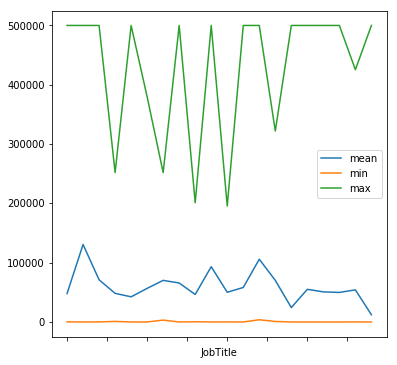

In [31]:
SalaryVisual.groupby("JobTitle").YearlyCompensation.agg(['mean', 'min', 'max']).plot(figsize=(6,6))

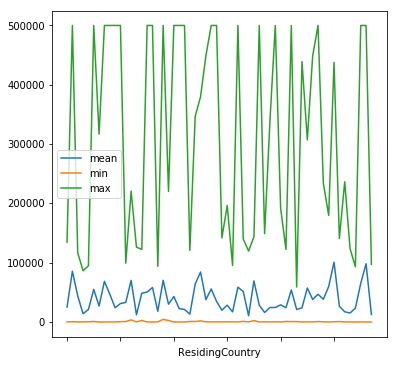

In [32]:
SalaryVisual.groupby("ResidingCountry").YearlyCompensation.agg(['mean', 'min', 'max']).plot(figsize=(6,6))

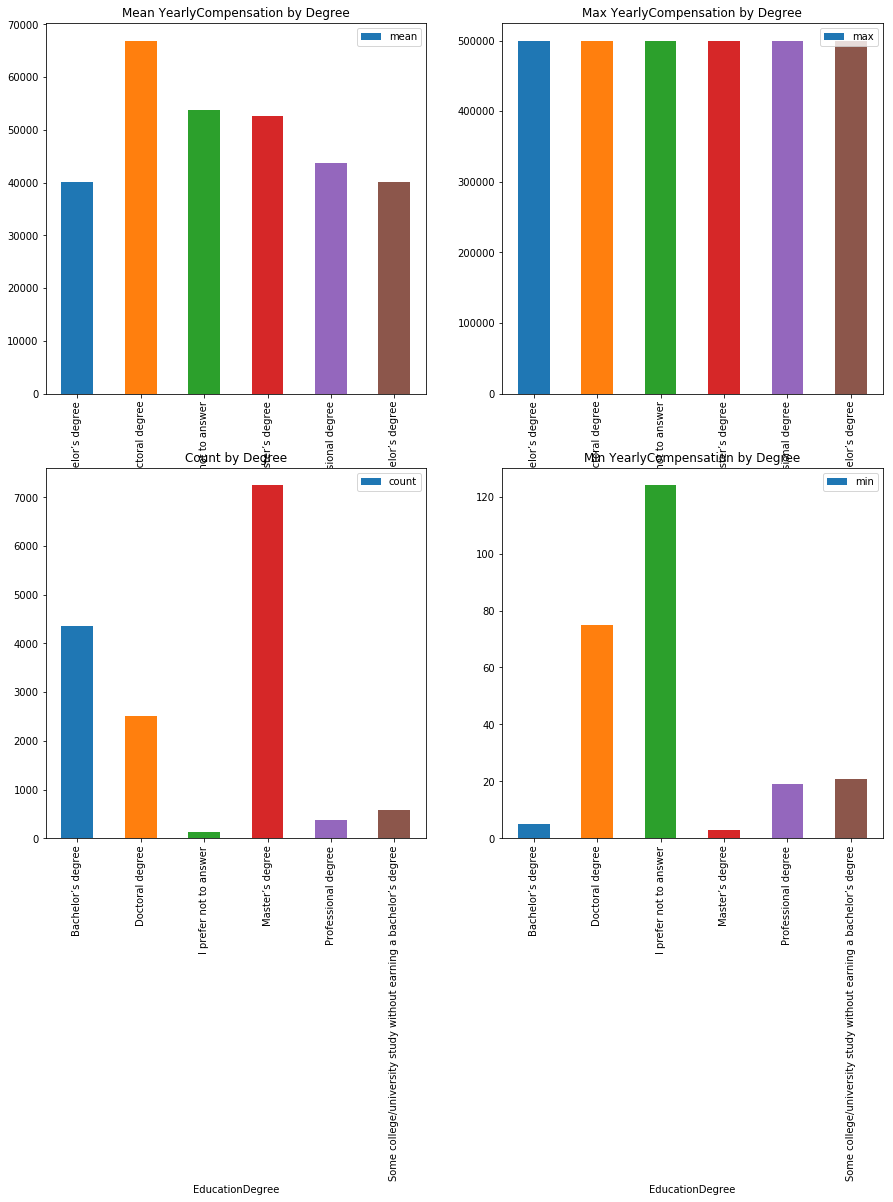

In [33]:
compensation_by_degree=SalaryVisual.groupby("EducationDegree").YearlyCompensation.agg(['count', 'mean', 'min', 'max'])
fig, axes = plt.subplots(nrows=2, ncols=2)
compensation_by_degree.plot(y='mean',kind="bar",title="Mean YearlyCompensation by Degree",ax=axes[0,0],figsize=(15,15))
compensation_by_degree.plot(y='max',kind="bar",title="Max YearlyCompensation by Degree",ax=axes[0,1])
compensation_by_degree.plot(y='count',kind="bar",title="Count by Degree",ax=axes[1,0])
compensation_by_degree.plot(y='min',kind="bar",title="Min YearlyCompensation by Degree",ax=axes[1,1])
plt.show()

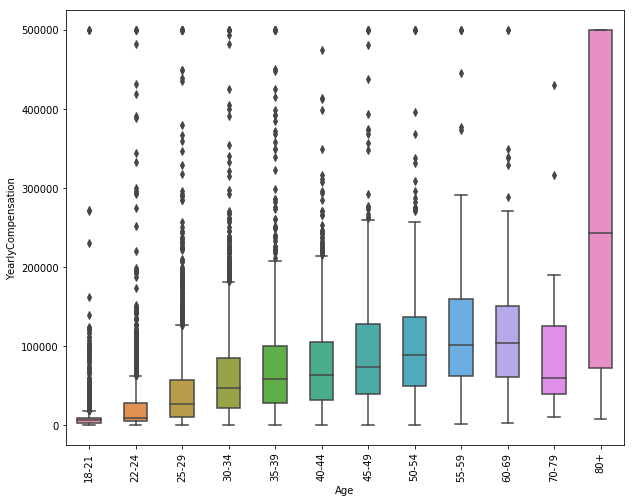

In [34]:
#box plot Age/salary
var = 'Age'
order=["18-21","22-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-69","70-79","80+"]
data = pd.concat([SalaryVisual['YearlyCompensation'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x=var, y="YearlyCompensation", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

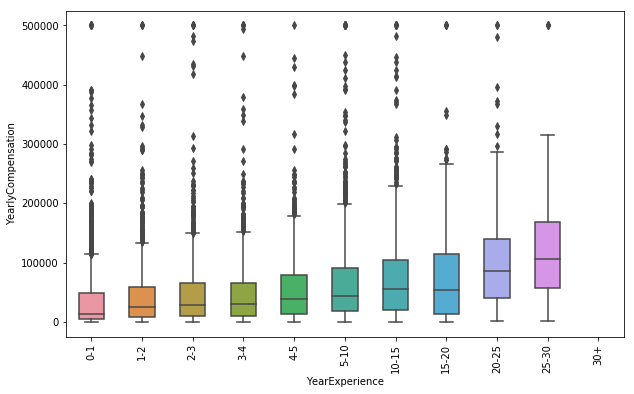

In [35]:
#box plot YearExperience/salary
var = 'YearExperience'
order=["0-1","1-2","2-3","3-4","4-5","5-10","10-15","15-20","20-25","25-30","30+"]
data = pd.concat([SalaryVisual['YearlyCompensation'], SalaryVisual[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x=var, y="YearlyCompensation", data=SalaryVisual,width=0.5,order=order)
_ = fig.set_xticklabels(fig.get_xticklabels(),rotation=90)

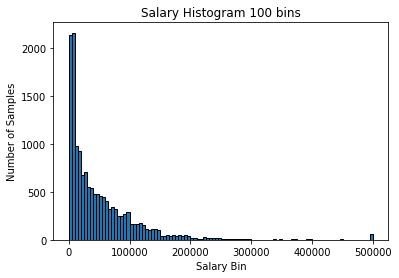

In [36]:
%matplotlib inline

plt.hist(SalaryVisual['YearlyCompensation'], bins=100, edgecolor='black')
plt.title("Salary Histogram 100 bins")
plt.xlabel("Salary Bin")
plt.ylabel("Number of Samples")
plt.show()

### 2.2

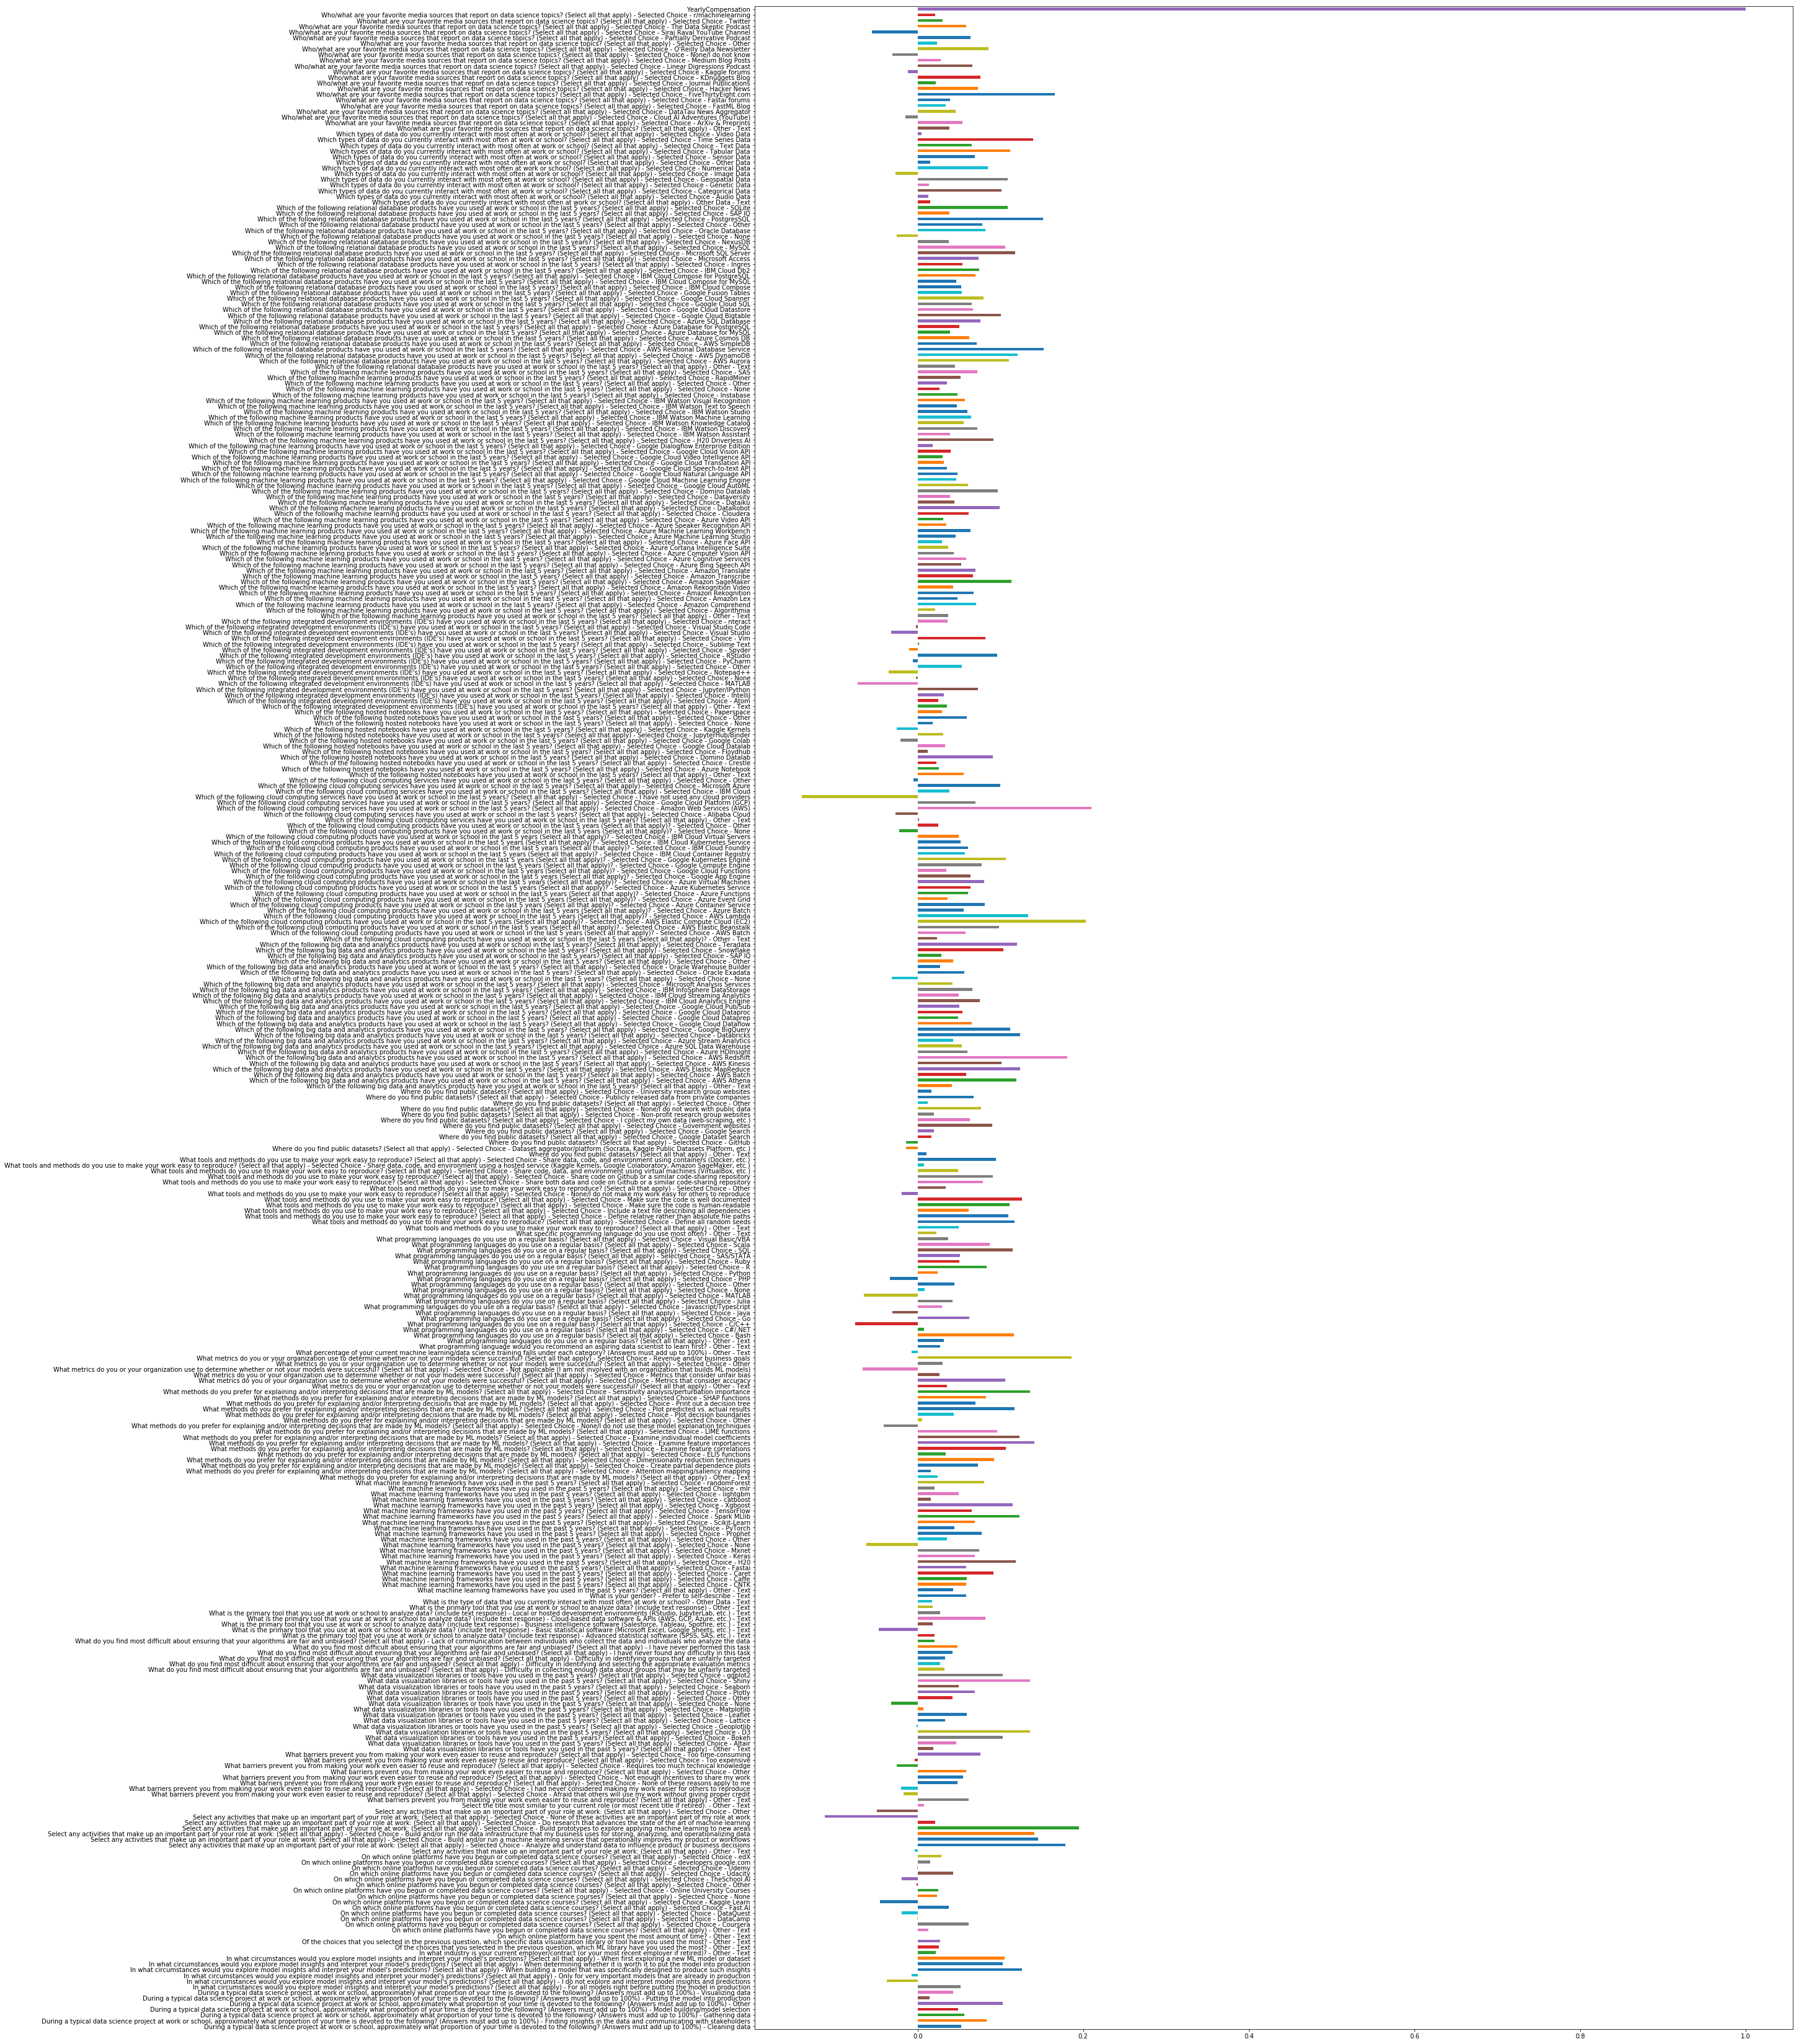

In [37]:
for col in SalaryVisual.columns:
    if len(SalaryVisual[col].value_counts())==1:
        SalaryVisual.drop([col], axis=1,inplace=True)

corr = SalaryVisual.corr()
(corr.YearlyCompensation.sort_index().plot(kind="barh",figsize=(30,60)))

In [38]:
print("TOP 5 negative Correlation with Salary:")
print(corr.YearlyCompensation.sort_values()[0:5],"\n")

print("TOP 5 positive Correlation with Salary:")
print(corr.YearlyCompensation.sort_values()[-7:])

TOP 5 negative Correlation with Salary:
Which of the following cloud computing services have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - I have not used any cloud providers                                              -0.139860
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work                                          -0.111810
What programming languages do you use on a regular basis? (Select all that apply) - Selected Choice - C/C++                                                                                                                       -0.075244
Which of the following integrated development environments (IDE's) have you used at work or school in the last 5 years? (Select all that apply) - Selected Choice - MATLAB                                                        -0.072165
What metrics do 

In [39]:
for col in Salary.columns:
    if len(Salary[col].value_counts())==1:
        Salary.drop([col], axis=1,inplace=True)

In [40]:
Salary.drop(Salary[Salary.Yearly_compensation < 1000].index, inplace=True)
Salary.drop(Salary[Salary.Yearly_compensation > 350000].index, inplace=True)

In [41]:
for col in Salary.columns: 
    if Salary[col].isna().any():
        print(col)

for col in Salary.columns: 
    if isinstance(Salary.loc[1,col],str):
        print(col)

In [42]:
X = Salary.drop(['Yearly_compensation'],axis=1)
Y = Salary['Yearly_compensation']

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X,Y,test_size=0.3, random_state=20)

# Q3 Feature selection

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def feature_scaling(X_Train, X_Test, method):
    methodmap = {'z-score':StandardScaler(),'min-max':MinMaxScaler(),'robust':RobustScaler()}
    if method not in ['z-score','min-max','robust']:
        print("We don't have this kind of method for normalization. Please choose from ['z-score','min-max','robust']")
        return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
    else:
        ss = methodmap[method].fit(X_Train)
        X_Train = ss.transform(X_Train)
        X_Test = ss.transform(X_Test)
        return pd.DataFrame(X_Train), pd.DataFrame(X_Test)

In [44]:
X_Train.shape

(10252, 604)

In [45]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.decomposition import PCA

def feature_elimination(X_Train, X_Test, Y_Train, method='pca', para=None):
    if method not in ['variance','pca','mul_info']:
        print("We don't have this kind of method for normalization. Please choose from ['variance','pca','mul_info']")
        return X_Train, X_Test
    else:
        if method=='variance':
            Para = para if para else (.008 * (1 - .008))
            sel = VarianceThreshold(threshold = Para).fit(X_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        elif method=='mul_info':
            Para = para if para else 200
            sel = SelectKBest(mutual_info_classif, k=Para).fit(X_Train,Y_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)
        else:
            Para = para if para else 200
            sel = PCA(n_components=Para).fit(X_Train)
            X_Train = sel.transform(X_Train)
            X_Test = sel.transform(X_Test)
            return pd.DataFrame(X_Train), pd.DataFrame(X_Test)

In [46]:
def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    # m = y_predict.shape[0]
    avg = np.average(y_predict)
    return np.sqrt(np.average(np.power((avg-y),2)))
def variance(y_predict):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

In [47]:
from collections import OrderedDict

from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso as lasso
from sklearn.linear_model import ElasticNet as elsnet
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import GradientBoostingRegressor as gbr

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error
from sklearn.metrics import roc_auc_score, roc_curve, auc,confusion_matrix,accuracy_score

def two_score(y_true,y_pred):    
    mean_squared_error(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = r2_score(y_true,y_pred)
    return score

def run_kfold(model,X,y,folds=10):
    kf = KFold(n_splits=folds)
    kf.get_n_splits(X)
    score_keep = []
    trade_keep = []
    fold = 0
    print("The result with {}-fold cross-validation on training set".format(folds))

    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)

        train_r2 = r2_score(y_train, y_train_predict)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_predict))
        train_mae = mean_absolute_error(y_test, y_test_predict)
        
        test_r2 = r2_score(y_test, y_test_predict)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_predict))
        test_mae = mean_absolute_error(y_test, y_test_predict)
        # print("Fold {} R2 training score: {}, testing score: {}".format(fold,train_r2,test_r2))
        # print("RMSE training score: {}, testing score: {}".format(train_rmse,test_rmse))
        train_bia = bias(y_train_predict,y_train)
        train_var = variance(y_train_predict)
        train_total = train_bia + train_var
        
        test_bia = bias(y_test_predict,y_train)
        test_var = variance(y_test_predict)
        test_total = test_bia + test_var
        # scores = clf.predict_proba(X_train)
        # bia = bias(y_train_predict,y_train)
        # var = variance(scores,y_train)
        # total = bia + var
        score_keep.append((train_r2, test_r2,train_rmse, test_rmse,train_mae,test_mae))
        trade_keep.append((train_bia,test_bia,train_var,test_var,train_total,test_total))
    score_df = pd.DataFrame(score_keep, columns=["train_R2","test_R2","train_RMSE","test_RMSE","train_MAE","test_MAE"])
    trade_df = pd.DataFrame(trade_keep, columns=["train_bia","test_bia","train_var","test_var","train_total","test_total"])
    print(score_df.describe()[1:4])
    return clf, score_df, trade_df

class Regressor(object):
    def __init__(self,train_data,train_targets):
        super().__init__()
        self.train_data = train_data
        self.train_targets = train_targets
        rfrhyperpara = {'n_estimators': list(range(90,120,5)),'max_depth': list(range(35,45,3)),'min_samples_leaf': [1, 2, 3]}
        gbrhyperpara = {'n_estimators': list(range(85,110,5)),'max_depth': list(range(4,15,3)),'min_samples_leaf': [1, 2]}
        self.models=OrderedDict([('LinearRegression',[lr(),None]),\
                            ('Lasso',[lasso(alpha=9.0,max_iter=2000,random_state=20),dict(alpha=np.arange(0.1,10,0.5))]),\
                            ('ElasticNet',[elsnet(l1_ratio=0.8),dict(l1_ratio=np.linspace(0,1,10))]),\
                            ('RandomForest',[rfr(n_estimators = 105, max_depth=40, min_samples_leaf=2),rfrhyperpara]),\
                            ('GradientBoosting',[gbr(),gbrhyperpara])])
        #1.1 and 2.70 # ElasticNet(alpha=1.0, l1_ratio=0.5）
    def train_model(self,model_name,scorer="R2",ifhyper_tune=False,hyper_paras="",folder=10):
        self.model_name = model_name
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                if scorer=='R2':
                    acc_scorer = make_scorer(r2_score)
                elif scorer == 'RMSE':
                    acc_scorer = make_scorer(mean_squared_error)
                else:
                    acc_scorer = make_scorer(two_score, greater_is_better=True)
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring=acc_scorer, n_jobs=-1) 

                grid.fit(self.train_data, self.train_targets)
                print('The best score of model {} through {}-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, 5, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_targets)
            train_pred = best_model.predict(self.train_data)
            R2 = r2_score(self.train_targets,train_pred)
            # print('The R2 score of {} model is {}\n'.format(model_name,score))
            RMSE = np.sqrt(mean_squared_error(self.train_targets,train_pred))
            MAE = mean_absolute_error(self.train_targets,train_pred)
            score_df = pd.DataFrame([(R2,RMSE,MAE)], columns=["R2", "RMSE","MAE"])
            # print('The RMSE score of {} model is {}\n'.format(model_name,score))         
        else:
            best_model, score_df, trade_df = run_kfold(model,self.train_data,self.train_targets,folder)
        
        self.best_model = best_model
        
        return best_model, score_df, trade_df

    def test_model(self,test_data,test_targets): #,if_report=False):
        test_pred = self.best_model.predict(test_data)

        R2 = r2_score(test_targets, test_pred)
        RMSE = np.sqrt(mean_squared_error(test_targets,test_pred))
        MAE = mean_absolute_error(test_targets,test_pred)
        BIAS = bias(test_pred,test_targets)
        VAR = variance(test_pred)
        TOTAL = BIAS + VAR
        #test accuracy
        print("Testing Result:")
        print('Model {} has R2 score {} on Testing\n'.format(self.model_name, R2))
        print('Model {} has RMSE socre {} on Testing\n'.format(self.model_name, RMSE))
        print('Model {} has MeanAbsoluteError {} on Testing\n'.format(self.model_name, MAE))
        print('Model {} has bias {} on Testing\n'.format(self.model_name, BIAS))
        print('Model {} has variance socre {} on Testing\n'.format(self.model_name, VAR))
        print('Model {} has total bias+variance {} on Testing\n'.format(self.model_name, TOTAL))
        #test result report
        '''
        if if_report:
            print('Test result report:\n\n', classification_report(test_labels, test_pred),'\n')
            if len(set(test_labels))==2:
                test_score = best_model.predict_proba(test_data)
                print('ROC plot and corresponding AUC:\n')
                self.plot_roc(test_labels,test_score)
            elif len(set(test_labels))>2:
                self.plot_confusion_matrix(cm)
        '''
        return R2, RMSE, MAE, BIAS, VAR, TOTAL

    def plot_roc(self,true, score):
        preds = score[:,1]
        fpr, tpr, threshold = roc_curve(true, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_confusion_matrix(self,cm):
        # plot the confusion matrix
        plt.figure(figsize=(10,10))
        plt.matshow(cm, fignum=1)

        # add labels for all targets
        num_targets = cm.shape[0]
        plt.xticks(list(range(num_targets+1)))
        plt.yticks(list(range(num_targets+1)))

In [48]:
AllFeatureReg = Regressor(X_Train,Y_Train)

In [50]:
lr_model, lr_score, lr_trade = AllFeatureReg.train_model('LinearRegression')
# AllFeatureReg.test_model(X_Test,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.612923  0.551277  31960.447404  34354.119959  23134.790977   
std   0.003694  0.034688    226.214024   2080.176366    960.809117   
min   0.605823  0.511392  31613.931719  30612.877265  21224.597822   

          test_MAE  
mean  23134.790977  
std     960.809117  
min   21224.597822  


In [51]:
lasso_model, lasso_score,lasso_trade = AllFeatureReg.train_model('Lasso')
# AllFeatureReg.test_model(X_Test,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.611467  0.557805  32020.509850  34104.761843  22873.815983   
std   0.003691  0.034470    225.992004   2102.635532    978.628423   
min   0.604381  0.518169  31672.288041  30346.692560  20973.874084   

          test_MAE  
mean  22873.815983  
std     978.628423  
min   20973.874084  


In [52]:
# lasso_model, lasso_score = AllFeatureReg.train_model('Lasso','R2',ifhyper_tune=True)
# AllFeatureReg.test_model(X_Test,Y_Test)

In [53]:
elsnet_model,elsnet_score,elsnet_trade = AllFeatureReg.train_model('ElasticNet')
# AllFeatureReg.test_model(X_Test,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.495615  0.476517  36483.468704  37108.942582  25152.188814   
std   0.003504  0.035260    212.561920   2051.154795    953.177534   
min   0.488541  0.422768  36238.245667  33420.062764  23246.137237   

          test_MAE  
mean  25152.188814  
std     953.177534  
min   23246.137237  


In [54]:
# elsnet_model,elsnet_score = AllFeatureReg.train_model('ElasticNet',ifhyper_tune=True)
# AllFeatureReg.test_model(X_Test,Y_Test)

In [55]:
rfr_model, rfr_score, rfr_trade = AllFeatureReg.train_model('RandomForest')
# AllFeatureReg.test_model(X_Test,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.901299  0.574320  16138.837738  33483.714620  21140.629185   
std   0.001605  0.032177    174.969470   2363.595776   1072.437918   
min   0.898317  0.510503  15832.517343  29853.237984  19658.077819   

          test_MAE  
mean  21140.629185  
std    1072.437918  
min   19658.077819  


In [56]:
#rfr_model, rfr_score = AllFeatureReg.train_model('RandomForest',ifhyper_tune=True)
#AllFeatureReg.test_model(X_Test,Y_Test)

In [57]:
gbr_model, gbr_score, gbr_trade = AllFeatureReg.train_model('GradientBoosting')
# AllFeatureReg.test_model(X_Test,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.647985  0.582868  30478.504043  33132.732926  21106.975858   
std   0.004096  0.032006    249.182403   2170.581429    973.322322   
min   0.641191  0.527329  30016.646841  29362.715153  19380.314441   

          test_MAE  
mean  21106.975858  
std     973.322322  
min   19380.314441  


In [58]:
## Takes long time
# gbr_model, gbr_score = AllFeatureReg.train_model('GradientBoosting',ifhyper_tune=True)
# AllFeatureReg.test_model(X_Test,Y_Test)

In [59]:
X_Train_pca, X_Test_pac = feature_elimination(X_Train,X_Test,Y_Train,'pca',400)
X_Train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,-311.490610,-34.281280,-49.046620,-25.746131,-3.745204,-0.689903,-10.090809,-12.023605,-17.765393,5.187417,...,-0.098389,0.009664,0.046149,-0.066838,0.042063,-0.015638,-0.007462,-0.029571,-0.022839,0.004306
1,694.369863,-18.101372,-26.836739,-33.198241,-0.214714,-12.270482,-7.806746,-2.874586,-2.580502,-6.205449,...,0.077214,0.017882,0.014246,0.164341,0.170325,-0.212404,0.077342,0.118520,-0.055982,0.030702
2,-315.035934,135.402669,-7.421459,-34.396174,-10.529478,-9.234264,-7.277452,2.530127,6.738319,41.119283,...,0.011324,0.129940,0.093594,0.043999,-0.015215,0.058347,0.017310,0.019711,-0.045637,-0.020524
3,-310.297238,-34.426286,-48.743499,-26.870174,-3.765195,-11.557323,-8.414177,-8.359618,-6.953417,-1.681191,...,0.138526,-0.107006,-0.250503,0.071002,-0.073192,-0.037877,-0.021285,-0.188906,-0.011942,0.305227
4,-311.913743,-12.753604,-43.756078,-27.909474,-4.348295,-11.087389,-8.132278,-8.447800,-7.556668,-2.490106,...,-0.273610,-0.057903,-0.010274,-0.114737,-0.199962,-0.079743,0.027990,0.052760,0.003306,0.111932


In [60]:
PcaFeatureReg = Regressor(X_Train_pca,Y_Train)

In [61]:
lr_model, lr_score, lr_trade = PcaFeatureReg.train_model('LinearRegression')
# PcaFeatureReg.test_model(X_Test_pac,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.573879  0.530615  33533.777967  35146.079976  23933.614103   
std   0.003333  0.031239    221.382153   2063.789982   1046.100097   
min   0.567275  0.495654  33226.247377  31766.782489  22151.633618   

          test_MAE  
mean  23933.614103  
std    1046.100097  
min   22151.633618  


In [62]:
lasso_model, lasso_score, lasso_trade = PcaFeatureReg.train_model('Lasso')
# PcaFeatureReg.test_model(X_Test_pac,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.573652  0.532097  33542.686744  35090.794441  23855.202471   
std   0.003331  0.031268    221.277467   2070.529580   1036.127958   
min   0.567057  0.497229  33235.399916  31694.209864  22069.710780   

          test_MAE  
mean  23855.202471  
std    1036.127958  
min   22069.710780  


In [63]:
elsnet_model, elsnet_score, elsnet_trade = PcaFeatureReg.train_model('ElasticNet')
# PcaFeatureReg.test_model(X_Test_pac,Y_Test)

The result with 10-fold cross-validation on training set
      train_R2   test_R2    train_RMSE     test_RMSE     train_MAE  \
mean  0.492787  0.474421  36585.628395  37183.088777  25226.808936   
std   0.003500  0.035275    212.350160   2047.361023    954.768880   
min   0.485765  0.419636  36343.746658  33512.574184  23328.491512   

          test_MAE  
mean  25226.808936  
std     954.768880  
min   23328.491512  


In [64]:
rfr_model, rfr_score, rfr_trade = PcaFeatureReg.train_model('RandomForest')
# PcaFeatureReg.test_model(X_Test_pac,Y_Test)

The result with 10-fold cross-validation on training set


KeyboardInterrupt: 

In [ ]:
gbr_model, gbr_score, gbr_trade = PcaFeatureReg.train_model('GradientBoosting')
# PcaFeatureReg.test_model(X_Test_pac,Y_Test)

In [ ]:
X_Train_mul, X_Test_mul = feature_elimination(X_Train,X_Test,Y_Train,'mul-info',400)
MulFeatureReg = Regressor(X_Train_mul,Y_Train)

In [ ]:
lr_model, lr_score, lr_trade = MulFeatureReg.train_model('LinearRegression')

In [ ]:
lasso_model, lasso_score, lasso_trade = MulFeatureReg.train_model('Lasso')

In [ ]:
elsnet_model,elsnet_score, elsnet_trade = MulFeatureReg.train_model('ElasticNet')

In [ ]:
rfr_model, rfr_score, rfr_trade = MulFeatureReg.train_model('RandomForest')

In [ ]:
gbr_model, gbr_score, gbr_trade = MulFeatureReg.train_model('GradientBoosting')